Circular Restricter 3 Body Problem (CR3BP)
Dynamics propagation

In [1]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

Propagation functions

In [2]:
def halo_propagator_with_STM(state,t):
    x = state[0]
    y = state[1]
    z = state[2]
    vx = state[3]
    vy = state[4]
    vz = state[5]
    mu = state[42]
    r1 = np.sqrt((x+mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x-1+mu)**2 + y**2 + z**2)
    
    statedot = np.zeros((43,1))
    statedot[0] = vx
    statedot[1] = vy
    statedot[2] = vz
    statedot[3] = x + 2*vy - (1-mu)*(x+mu)/(r1**3) - mu*(x-1+mu)/(r2**3)
    statedot[4] = y - 2*vx -(1-mu)*y/(r1**3) - mu*y/(r2**3)
    statedot[5] = -(1-mu)*z/(r1**3) - mu*z/(r2**3)
    
    dUdxx = 1 - (1-mu)/(r1**3) + 3*(1-mu)*(x+mu)**2/(r1**5) - mu/(r2**3) + 3*mu*(x-1+mu)**2/(r2**5)
    dUdyy = 1 - (1-mu)/(r1**3) + 3*(1-mu)*(y**2)/(r1**5) - mu/(r2**3) + 3*mu*(y**2)/(r2**5)
    dUdzz = -(1-mu)/(r1**3) + 3*(1-mu)*(z**2)/(r1**5) - mu/(r2**3) + 3*mu*(z**2)/(r2**5)
    dUdxy = 3*(1-mu)*(x+mu)*y/(r1**5) + 3*mu*(x-1+mu)*y/(r2**5)
    dUdxz = 3*(1-mu)*(x+mu)*z/(r1**5) + 3*mu*(x-1+mu)*z/(r2**5)
    dUdyz = 3*(1-mu)*y*z/(r1**5) + 3*mu*y*z/(r2**5)
    
    A = np.matrix([[0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1],
         [dUdxx, dUdxy, dUdxz, 0, 2, 0],
         [dUdxy, dUdyy, dUdyz, -2, 0, 0],
         [dUdxz, dUdyz, dUdzz, 0, 0, 0]])

    STM = np.matrix([[state[6], state[7], state[8], state[9], state[10], state[11]],
           [state[12], state[13], state[14], state[15], state[16], state[17]],
           [state[18], state[19], state[20], state[21], state[22], state[23]],
           [state[24], state[25], state[26], state[27], state[28], state[29]],
           [state[30], state[31], state[32], state[33], state[34], state[35]],
           [state[36], state[37], state[38], state[39], state[40], state[41]]])
    
    dSTMdt = A@STM
    # print(statedot[6:12].shape,dSTMdt[0,:].shape,dSTMdt[0,:].T.shape)
    statedot[6:12] = dSTMdt.T[:,0]
    statedot[12:18] = dSTMdt.T[:,1]
    statedot[18:24] = dSTMdt.T[:,2]
    statedot[24:30] = dSTMdt.T[:,3]
    statedot[30:36] = dSTMdt.T[:,4]
    statedot[36:42] = dSTMdt.T[:,5]
    # print(statedot,statedot.reshape(len(statedot)))
    return statedot.reshape(len(statedot))

def halo_propagator(state,t):
    x = state[0]
    y = state[1]
    z = state[2]
    vx = state[3]
    vy = state[4]
    mu = state[6]
    r1 = np.sqrt((x+mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x-1+mu)**2 + y**2 + z**2)
    
    statedot = np.zeros(7)
    statedot[0] = vx
    statedot[1] = vy
    statedot[2] = state[5]
    statedot[3] = x + 2*vy - (1-mu)*(x+mu)/(r1**3) - mu*(x-1+mu)/(r2**3)
    statedot[4] = y - 2*vx -(1-mu)*y/(r1**3) - mu*y/(r2**3)
    statedot[5] = -(1-mu)*z/(r1**3) - mu*z/(r2**3)
    return statedot

def single_shooting(initial_state,residual,jacobian):
    new_initial_state = initial_state.reshape((3,1)) - np.linalg.pinv(jacobian)@(residual.reshape((3,1)))
    return new_initial_state

def optimization(initial_conditions,period,max_iter=1000,tol=1e-5,step=3000):
    adjusted_conditions = initial_conditions
    tf = period/2
    t_simulation = np.linspace(0,tf,step)
    
    for i in range(max_iter):
        # integrate to get the position at the end of one orbit
        print(adjusted_conditions,t_simulation)
        y_temp = integrate.odeint(halo_propagator_with_STM,adjusted_conditions,t_simulation,rtol=1e-12, atol=1e-12)
        f = np.matrix([y_temp[-1,1], y_temp[-1,3], y_temp[-1,5]])
        print(np.linalg.norm(f))
        
        if np.linalg.norm(f)<tol:
            adjusted_conditions[0] = y_temp[0,0]
            adjusted_conditions[4] = y_temp[0,4]
            break
        else:
            # use the ode function to compute the derivatives easily
            state_end = halo_propagator(y_temp[-1,:],t_simulation[-1])
            
            df = np.matrix([[y_temp[-1,12], y_temp[-1,16], state_end[1]],
                  [y_temp[-1,24], y_temp[-1,28], state_end[3]],
                  [y_temp[-1,36], y_temp[-1,40], state_end[5]]])
            
            new_x = single_shooting(np.matrix([adjusted_conditions[0],adjusted_conditions[4],tf]),f,df) # changer les arguments
            # print(new_x[1,0])
            adjusted_conditions[0] = new_x[0,0]
            adjusted_conditions[4] = new_x[1,0]
            tf = new_x[2,0]
    
    return adjusted_conditions,tf

In [3]:
r12 = 389703 # km, distance between primary attractors
mu = 1.215058560962404e-2 # no unit, mass parameter of the system
TU = 382981 # s, inverse of the relative angular frequency between the two primary attractors
L1x = 0.83691513 # nd, position of the L1 point along the x direction
L2x = 1.15568217 # nd, position of the L2 point along the x direction

Initial guess

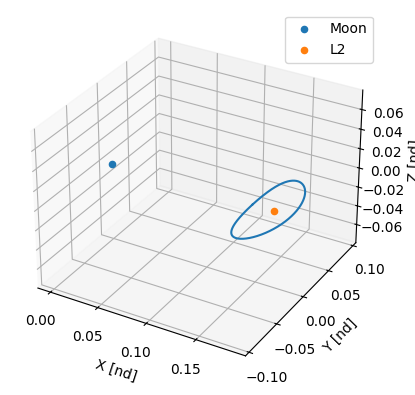

In [4]:
x0 = 1.1340389525913128E+0 # nd, for Lyapounov orbit about L1: 8.2967381582787081E-1
y0 = -1.9603275922757012E-28 # nd, for Lyapounov orbit about L1: 4.5691881617111996E-29
z0 = -3.1177930540447237E-33 # nd, for Lyapounov orbit about L1: -2.4095847440443644E-32
vx0 = 5.3802690301291542E-15 # nd, for Lyapounov orbit about L1: 2.7691850370932105E-16
vy0 = 1.1050885595242482E-1 # nd, for Lyapounov orbit about L1: 6.4159717067070993E-2
vz0 = 4.2488243310471582E-33 # nd, for Lyapounov orbit about L1: 4.2674206516771668E-32
period = 3.3898323438578979E+0 # in TU, for Lyapounov orbit about L1: 2.7041588513971861E+0

initial_state = [x0, y0, z0, vx0, vy0, vz0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 
                 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, mu]

t_simulation = np.linspace(0,period,6000)
y_orbit = integrate.odeint(halo_propagator_with_STM,initial_state,t_simulation)

# Plot the orbit before single-shooting differenciation correction
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_orbit[:,0]-(1-mu), y_orbit[:,1], y_orbit[:,2])
ax.scatter(0, 0, 0, label='Moon')
ax.scatter(L2x-(1-mu), 0, 0, label='L2')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.grid()
plt.show()


[1.1340389525913128, -1.9603275922757012e-28, -3.117793054044724e-33, 5.380269030129154e-15, 0.11050885595242482, 4.248824331047158e-33, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0.01215058560962404] [0.00000000e+00 5.65160444e-04 1.13032089e-03 ... 1.69378585e+00
 1.69435101e+00 1.69491617e+00]
1.4991425862741217e-13
[1.1340389525913128, -1.9603275922757012e-28, -3.117793054044724e-33, 5.380269030129154e-15, 0.11050885595242482, 4.248824331047158e-33, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0.01215058560962404] 1.694916171928949


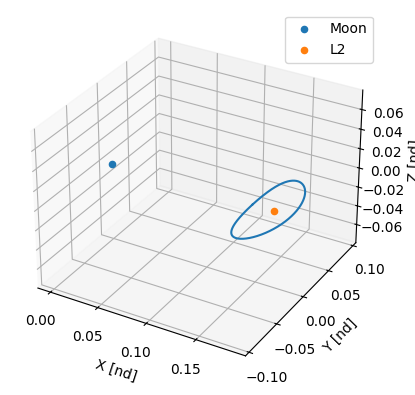

In [5]:
[adjusted_conditions,tf] = optimization(initial_state,period)
print(adjusted_conditions,tf)

# Plotting the orbit after adjusting initial conditions
y_orbit2 = integrate.odeint(halo_propagator_with_STM,adjusted_conditions,t_simulation)

# Plot the orbit before single-shooting differenciation correction
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_orbit2[:,0]-(1-mu), y_orbit2[:,1], y_orbit2[:,2])
ax.scatter(0, 0, 0, label='Moon')
ax.scatter(L2x-(1-mu), 0, 0, label='L2')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.grid()
plt.show()